## XGBoost多分类
任务: 使用鸢尾花的数据来说明多分类的问题  
损失：
Multi-classification的问题可以用Multi-LogLoss

$$
\text{Multi-LogLoss}=-\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^m y_{i,j}\log (p_{i,j}).
$$
其中n是预测样本的个数

m是class的数量

yi,j是真实的分类，如果第i个样本属于第j个class，那么yi,j=1
log是自然对数

pi,j是模型预测出来第i个样本属于第j个class的概率

### 数据准备

In [1]:
from sklearn import datasets 
from sklearn.model_selection import train_test_split
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import accuracy_score

In [2]:
iris = datasets.load_iris()
data = iris.data
data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [3]:
#一共有150个样本数据, 维度为4维
label = iris.target
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### 数据可视化

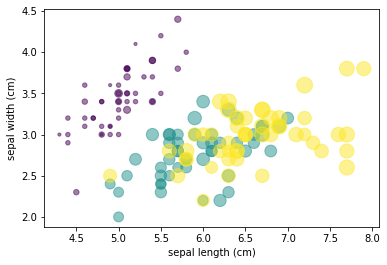

In [4]:
feature = iris.data.T
plt.scatter(feature[0], feature[1], alpha=0.5, s=100*feature[3], c=iris.target)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

In [5]:
# 划分数据集
train_x, test_x, train_y, test_y = train_test_split(data, label, random_state=0)

dtrain = xgb.DMatrix(train_x,label=train_y)
dtest = xgb.DMatrix(test_x)

### 调整参数

0. 确定模型的目标：分类、回归、排序
- objective  
- “reg:linear” —— 线性回归。  
- “reg:logistic”—— 逻辑回归。  
- “binary:logistic”—— 二分类的逻辑回归问题，输出为概率。  
- “binary:logitraw”—— 二分类的逻辑回归问题，输出的结果为wTx。  
- “count:poisson”—— 计数问题的poisson回归，输出结果为poisson分布。在poisson回归中，max_delta_step的缺省值为0.7。(used to safeguard optimization)
- “multi:softmax” –让XGBoost采用softmax目标函数处理多分类问题，同时需要设置参数num_class（类别个数）  
- “multi:softprob” –和softmax一样，但是输出的是ndata * nclass的向量，可以将该向量reshape成ndata行nclass列的矩阵。没行数据表示样本所属于每个类别的概率。  
- “rank:pairwise” –set XGBoost to do ranking task by minimizing the pairwise loss  
1. 首先调节eta和num_round来控制收敛速度和最大建树,两者之间相互制约，需要同时调整参数，故使用网格搜索进行调整。
- eta: xgboost在进行完一次迭代后，会将叶子节点的权重乘上该系数，主要是为了削弱每棵树的影响，让后面有更大的学习空间。实际应用中，一般把eta设置得小一点，然后迭代次数设置得大一点
- num_round: 建立弱分类器数量（也即迭代次数），其数量越大，模型的学习能力就会越强。但是，较大num_round会造成过拟合，且增加到一定程度之后，模型达到上限，不会在增加准确率。
2. gamma或者max_depth控制子树的复杂程度，减低模型复杂度（减少过拟合）
- max_depth: 默认值为６，通过控制输的深度从而控制树模型的复杂程度，来减少过拟合分风险。
- gamma: 树结点分裂的最低要求，能够减低过拟合
3. 调节横向或纵向的数据抽样比例
- subsample: boostrap抽样，让模型变的轻量，有放回抽样，可以减少过拟合。
- colsample_bytree:控制每棵树的特征抽取比例，减少过拟合的风险。
4. 正则化系数：L1: alpha L2: lambda0. 

#### 初始化状态(未调参)

In [6]:
param1 = {'verbosity':2
          , "tree_method":"gpu_hist"  # 使用GPU
          , "gpu_id": 0  # 指定GPU
          , 'objective': 'multi:softmax'  # 目标 
          , "num_class":3  # 指定多分类别数目
          , 'eval_metric':'mlogloss'
          
#           , "eta":0.01
          
#           , "gamma":0
#           , "max_depth":6

#           , "subsample":1  # 横向抽样
#           , "colsample_bytree":1  # 纵向抽样
#           , "colsample_bylevel":1
#           , "colsample_bynode":1

#           , "lambda":1  # L2
#           , "alpha":0  # L1
         }
num_round = 400
print("The time of param１:")
t0 = time()
cvresult1 = xgb.cv(params=param1, dtrain=dtrain, num_boost_round=num_round)
print(datetime.datetime.fromtimestamp(time()-t0).strftime("%M:%S:%f"))

The time of param１:
00:02:254538


#### 调整好的参数状态

In [7]:
param2 = {'verbosity':2
          , "tree_method":"gpu_hist"  # 使用GPU
          , "gpu_id": 0  # 指定GPU
          , 'objective': 'multi:softmax'  # 目标 
          , "num_class":3  # 指定多分类别数目
          , 'eval_metric':'mlogloss'
          
#           , "eta":0.01
          
#           , "gamma":0
#           , "max_depth":6

#           , "subsample":1  # 横向抽样
#           , "colsample_bytree":1  # 纵向抽样
#           , "colsample_bylevel":1
#           , "colsample_bynode":1

#           , "lambda":1  # L2
#           , "alpha":0  # L1
         }

t0 = time()
print("The time of param2:")
cvresult2 = xgb.cv(params=param2, dtrain=dtrain, num_boost_round=num_round)
print(datetime.datetime.fromtimestamp(time()-t0).strftime("%M:%S:%f"))

The time of param2:
00:02:002574


#### 调参数状态

In [8]:
param3 = {'verbosity':2
          , "tree_method":"gpu_hist"  # 使用GPU
          , "gpu_id": 0  # 指定GPU
          , 'objective': 'multi:softmax'  # 目标 
          , "num_class":3  # 指定多分类别数目
          , 'eval_metric':'mlogloss'
          
          , "eta":0.01
          
#           , "gamma":0
          , "max_depth":6

#           , "subsample":1  # 横向抽样
#           , "colsample_bytree":1  # 纵向抽样
#           , "colsample_bylevel":1
#           , "colsample_bynode":1

#           , "lambda":1  # L2
#           , "alpha":0  # L1
         }

print("The time of param3:")
t0 = time()
cvresult3 = xgb.cv(params=param3, dtrain=dtrain, num_boost_round=num_round)
print(datetime.datetime.fromtimestamp(time()-t0).strftime("%M:%S:%f"))

The time of param3:
00:02:332151


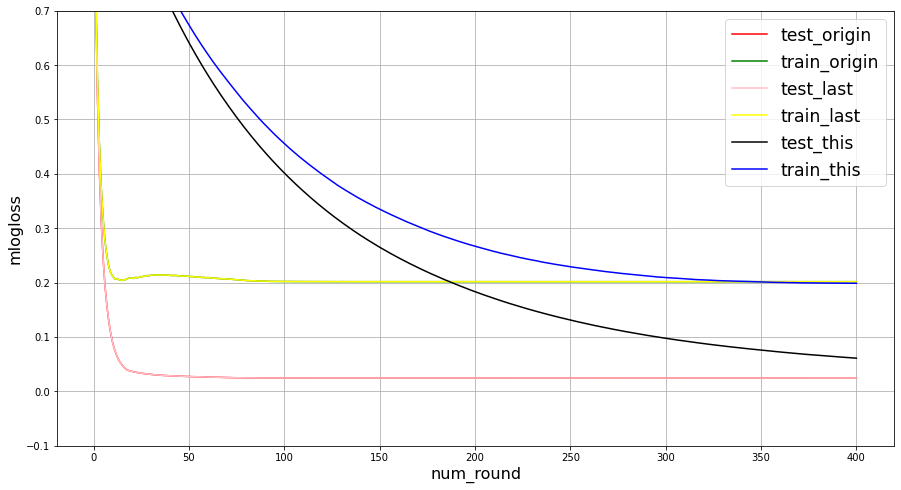

In [9]:
#　调整参数后的效果
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.grid()
end = num_round + 1

ax.plot(range(1, end), cvresult1.iloc[:, 0], c="red", label="test_origin")
ax.plot(range(1, end), cvresult1.iloc[:, 2], c="green", label="train_origin")

ax.plot(range(1, end), cvresult2.iloc[:, 0], c="pink", label="test_last")
ax.plot(range(1, end), cvresult2.iloc[:, 2], c="yellow", label="train_last")

ax.plot(range(1, end), cvresult3.iloc[:, 0], c="black", label="test_this")
ax.plot(range(1, end), cvresult3.iloc[:, 2], c="blue", label="train_this")

ax.legend(fontsize = "xx-large")
ax.set_ylim(bottom=-0.1, top=0.7)
plt.ylabel(cvresult1.columns[1].split("-")[1], fontsize=16)
plt.xlabel("num_round", fontsize=16)
plt.savefig("./imgs/cv.png")
plt.show()

### 评估(使用分分类错误率作为标准)

In [10]:
Multi_xgb = xgb.train(param1, dtrain, num_boost_round=400)

In [11]:
y_hat = Multi_xgb.predict(dtest)

#### 准确率

In [12]:
print("Accuracy:",round(accuracy_score(y_true=test_y, y_pred=y_hat), 4))

Accuracy: 0.9737


#### 特征重要性

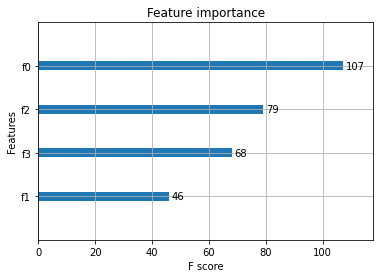

In [13]:
xgb.plot_importance(Multi_xgb)
plt.show()